# Project: Decoding Molecules From Fingerprints.
## Group Members:
### Qi Chen, e-mail: gusqichr@student.gu.se
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
***

In [1]:
import os
import io
import base64
from typing import List, Tuple
from concurrent.futures import ThreadPoolExecutor, as_completed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from PIL import Image
from collections import defaultdict
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import spearmanr

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit import DataStructs
from rdkit.DataStructs import TanimotoSimilarity
import requests
import time
import pandas as pd
from typing import Optional, List, Dict
from datetime import datetime
import urllib.parse
from IPython.display import display
from ipywidgets import interact, fixed, widgets

from joblib import Parallel, delayed
from sklearn.manifold import MDS, TSNE

# Pandas display settings
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

### Define directories
***

In [2]:
# Set user directory
USER_DIR = os.path.expanduser('~')

# Set the project root directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Define the input and output directories
INPUT_DIR = os.path.join(PROJECT_ROOT, 'data/bit_flipping_nn_review_1')

### Load Parecoxib, Celecoxib, Cimicoxib and Deracoxib, Anitrazafen Data
***

In [3]:
# Read 10 random single flips
parecoxib_df_10 = pd.read_parquet(os.path.join(INPUT_DIR, 'parecoxib_df_10_random_single_flips.parquet'))
print(f"Parecoxib shape: {parecoxib_df_10.shape}")

celecoxib_df_10 = pd.read_parquet(os.path.join(INPUT_DIR, 'celecoxib_df_10_random_single_flips.parquet'))
print(f"Celecoxib shape: {celecoxib_df_10.shape}")

cimicoxib_df_10 = pd.read_parquet(os.path.join(INPUT_DIR, 'cimicoxib_df_10_random_single_flips.parquet'))
print(f"Cimicoxib shape: {cimicoxib_df_10.shape}")

deracoxib_df_10 = pd.read_parquet(os.path.join(INPUT_DIR, 'deracoxib_df_10_random_single_flips.parquet'))
print(f"Deracoxib shape: {deracoxib_df_10.shape}")

anitrazafen_df_10 = pd.read_parquet(os.path.join(INPUT_DIR, 'anitrazafen_df_10_random_single_flips.parquet'))
print(f"Anitrazafen shape: {anitrazafen_df_10.shape}")

Parecoxib shape: (10, 9)
Celecoxib shape: (10, 9)
Cimicoxib shape: (10, 9)
Deracoxib shape: (10, 9)
Anitrazafen shape: (10, 9)


In [4]:
# Read 100 random single flips
parecoxib_df_100 = pd.read_parquet(os.path.join(INPUT_DIR, 'parecoxib_df_100_random_single_flips.parquet'))
print(f"Parecoxib shape: {parecoxib_df_100.shape}")

celecoxib_df_100 = pd.read_parquet(os.path.join(INPUT_DIR, 'celecoxib_df_100_random_single_flips.parquet'))
print(f"Celecoxib shape: {celecoxib_df_100.shape}")

cimicoxib_df_100 = pd.read_parquet(os.path.join(INPUT_DIR, 'cimicoxib_df_100_random_single_flips.parquet'))
print(f"Cimicoxib shape: {cimicoxib_df_100.shape}")

deracoxib_df_100 = pd.read_parquet(os.path.join(INPUT_DIR, 'deracoxib_df_100_random_single_flips.parquet'))
print(f"Deracoxib shape: {deracoxib_df_100.shape}")

anitrazafen_df_100 = pd.read_parquet(os.path.join(INPUT_DIR, 'anitrazafen_df_100_random_single_flips.parquet'))
print(f"Anitrazafen shape: {anitrazafen_df_100.shape}")

Parecoxib shape: (100, 9)
Celecoxib shape: (100, 9)
Cimicoxib shape: (100, 9)
Deracoxib shape: (100, 9)
Anitrazafen shape: (100, 9)


In [5]:
# Read 1000 random single flips
parecoxib_df_1000 = pd.read_parquet(os.path.join(INPUT_DIR, 'parecoxib_df_1000_random_single_flips.parquet'))
print(f"Parecoxib shape: {parecoxib_df_1000.shape}")

celecoxib_df_1000 = pd.read_parquet(os.path.join(INPUT_DIR, 'celecoxib_df_1000_random_single_flips.parquet'))
print(f"Celecoxib shape: {celecoxib_df_1000.shape}")

cimicoxib_df_1000 = pd.read_parquet(os.path.join(INPUT_DIR, 'cimicoxib_df_1000_random_single_flips.parquet'))
print(f"Cimicoxib shape: {cimicoxib_df_1000.shape}")

deracoxib_df_1000 = pd.read_parquet(os.path.join(INPUT_DIR, 'deracoxib_df_1000_random_single_flips.parquet'))
print(f"Deracoxib shape: {deracoxib_df_1000.shape}")

anitrazafen_df_1000 = pd.read_parquet(os.path.join(INPUT_DIR, 'anitrazafen_df_1000_random_single_flips.parquet'))
print(f"Anitrazafen shape: {anitrazafen_df_1000.shape}")

Parecoxib shape: (1000, 9)
Celecoxib shape: (1000, 9)
Cimicoxib shape: (1000, 9)
Deracoxib shape: (1000, 9)
Anitrazafen shape: (1000, 9)


### Validate generated SMILES
***

In [6]:
# Function to convert SMILES to molecule and check validity
def smiles_to_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None, mol

In [7]:
# Validate generated SMILES
parecoxib_df_10['Valid_SMILES'], parecoxib_df_10['Molecule'] = zip(*parecoxib_df_10['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
celecoxib_df_10['Valid_SMILES'], celecoxib_df_10['Molecule'] = zip(*celecoxib_df_10['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
cimicoxib_df_10['Valid_SMILES'], cimicoxib_df_10['Molecule'] = zip(*cimicoxib_df_10['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
deracoxib_df_10['Valid_SMILES'], deracoxib_df_10['Molecule'] = zip(*deracoxib_df_10['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
anitrazafen_df_10['Valid_SMILES'], anitrazafen_df_10['Molecule'] = zip(*anitrazafen_df_10['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))

parecoxib_df_100['Valid_SMILES'], parecoxib_df_100['Molecule'] = zip(*parecoxib_df_100['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
celecoxib_df_100['Valid_SMILES'], celecoxib_df_100['Molecule'] = zip(*celecoxib_df_100['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
cimicoxib_df_100['Valid_SMILES'], cimicoxib_df_100['Molecule'] = zip(*cimicoxib_df_100['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
deracoxib_df_100['Valid_SMILES'], deracoxib_df_100['Molecule'] = zip(*deracoxib_df_100['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
anitrazafen_df_100['Valid_SMILES'], anitrazafen_df_100['Molecule'] = zip(*anitrazafen_df_100['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))

parecoxib_df_1000['Valid_SMILES'], parecoxib_df_1000['Molecule'] = zip(*parecoxib_df_1000['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
celecoxib_df_1000['Valid_SMILES'], celecoxib_df_1000['Molecule'] = zip(*celecoxib_df_1000['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
cimicoxib_df_1000['Valid_SMILES'], cimicoxib_df_1000['Molecule'] = zip(*cimicoxib_df_1000['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
deracoxib_df_1000['Valid_SMILES'], deracoxib_df_1000['Molecule'] = zip(*deracoxib_df_1000['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))
anitrazafen_df_1000['Valid_SMILES'], anitrazafen_df_1000['Molecule'] = zip(*anitrazafen_df_1000['Generated_SMILES'].apply(lambda x: smiles_to_mol(x)))


In [8]:
def calculate_valid_smiles_percentage(df_dict):
    results = []
    
    for compound, df in df_dict.items():
        valid_smiles = df['Valid_SMILES'].sum()
        percentage = df['Valid_SMILES'].mean() * 100
        results.append({
            'Compound': compound,
            'Valid_SMILES': valid_smiles,
            'Percentage': percentage
        })
    
    return pd.DataFrame(results)

In [9]:
df_dict_10 = {
    'Parecoxib': parecoxib_df_10,
    'Celecoxib': celecoxib_df_10,
    'Cimicoxib': cimicoxib_df_10,
    'Deracoxib': deracoxib_df_10,
    'Anitrazafen': anitrazafen_df_10
}

valid_smiles_percentage_10 = calculate_valid_smiles_percentage(df_dict_10)
valid_smiles_percentage_10

,Compound,Valid_SMILES,Percentage
0,Parecoxib,10,100.0
1,Celecoxib,10,100.0
2,Cimicoxib,10,100.0
3,Deracoxib,10,100.0
4,Anitrazafen,10,100.0


In [10]:
df_dict_100 = {
    'Parecoxib': parecoxib_df_100,
    'Celecoxib': celecoxib_df_100,
    'Cimicoxib': cimicoxib_df_100,
    'Deracoxib': deracoxib_df_100,
    'Anitrazafen': anitrazafen_df_100
}
valid_smiles_percentage_100 = calculate_valid_smiles_percentage(df_dict_100)
valid_smiles_percentage_100


,Compound,Valid_SMILES,Percentage
0,Parecoxib,100,100.0
1,Celecoxib,100,100.0
2,Cimicoxib,100,100.0
3,Deracoxib,100,100.0
4,Anitrazafen,100,100.0


In [11]:
df_dict_1000 = {
    'Parecoxib': parecoxib_df_1000,
    'Celecoxib': celecoxib_df_1000,
    'Cimicoxib': cimicoxib_df_1000,
    'Deracoxib': deracoxib_df_1000,
    'Anitrazafen': anitrazafen_df_1000
}
valid_smiles_percentage_1000 = calculate_valid_smiles_percentage(df_dict_1000)
valid_smiles_percentage_1000

,Compound,Valid_SMILES,Percentage
0,Parecoxib,1000,100.0
1,Celecoxib,1000,100.0
2,Cimicoxib,1000,100.0
3,Deracoxib,1000,100.0
4,Anitrazafen,1000,100.0


### Tanimoto similarity
***

In [12]:
def calculate_tanimoto_safe(fp_bits1, fp_bits2):
    """
    Calculate Tanimoto similarity between two fingerprint bit vectors.
    """
    try:
        # Convert bit vectors to numpy arrays if they aren't already
        fp_bits1 = np.array(fp_bits1)
        fp_bits2 = np.array(fp_bits2)
        
        # Verify that both fingerprints have the same length
        if len(fp_bits1) != len(fp_bits2):
            print(f"Fingerprint lengths don't match: {len(fp_bits1)} vs {len(fp_bits2)}")
            return None
            
        # Calculate intersection (AND) and union (OR)
        intersection = np.sum(fp_bits1 & fp_bits2)
        union = np.sum(fp_bits1 | fp_bits2)
        
        # Avoid division by zero
        if union == 0:
            print("Warning: Union of fingerprints is zero")
            return 0.0
            
        # Calculate Tanimoto similarity
        tanimoto = intersection / union
        
        return float(tanimoto)
        
    except Exception as e:
        print(f"Error calculating Tanimoto similarity: {e}")
        return None

In [13]:
parecoxib_df_10['Tanimoto'] = parecoxib_df_10.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)
celecoxib_df_10['Tanimoto'] = celecoxib_df_10.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)
cimicoxib_df_10['Tanimoto'] = cimicoxib_df_10.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)
deracoxib_df_10['Tanimoto'] = deracoxib_df_10.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)
anitrazafen_df_10['Tanimoto'] = anitrazafen_df_10.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)

parecoxib_df_100['Tanimoto'] = parecoxib_df_100.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)
celecoxib_df_100['Tanimoto'] = celecoxib_df_100.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)
cimicoxib_df_100['Tanimoto'] = cimicoxib_df_100.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)
deracoxib_df_100['Tanimoto'] = deracoxib_df_100.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)
anitrazafen_df_100['Tanimoto'] = anitrazafen_df_100.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)

parecoxib_df_1000['Tanimoto'] = parecoxib_df_1000.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)
celecoxib_df_1000['Tanimoto'] = celecoxib_df_1000.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)
cimicoxib_df_1000['Tanimoto'] = cimicoxib_df_1000.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)
deracoxib_df_1000['Tanimoto'] = deracoxib_df_1000.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)
anitrazafen_df_1000['Tanimoto'] = anitrazafen_df_1000.apply(lambda row: calculate_tanimoto_safe(row['FingerprintBits'], row['FingerprintBitsFlipped']), axis=1)

In [14]:
average_similarity_parecoxib_10 = parecoxib_df_10['Tanimoto'].mean()
average_similarity_celecoxib_10 = celecoxib_df_10['Tanimoto'].mean()
average_similarity_cimicoxib_10 = cimicoxib_df_10['Tanimoto'].mean()
average_similarity_deracoxib_10 = deracoxib_df_10['Tanimoto'].mean()
average_similarity_anitrazafen_10 = anitrazafen_df_10['Tanimoto'].mean()
print('*** 10 random single flips ***')
print(f"Average Tanimoto Similarity for 10 random single flips Parecoxib: {average_similarity_parecoxib_10}")
print(f"Average Tanimoto Similarity for 10 random single flips Celecoxib: {average_similarity_celecoxib_10}")
print(f"Average Tanimoto Similarity for 10 random single flips Cimicoxib: {average_similarity_cimicoxib_10}")
print(f"Average Tanimoto Similarity for 10 random single flips Deracoxib: {average_similarity_deracoxib_10}")
print(f"Average Tanimoto Similarity for 10 random single flips Anitrazafen: {average_similarity_anitrazafen_10}")

average_similarity_parecoxib_100 = parecoxib_df_100['Tanimoto'].mean()
average_similarity_celecoxib_100 = celecoxib_df_100['Tanimoto'].mean()
average_similarity_cimicoxib_100 = cimicoxib_df_100['Tanimoto'].mean()
average_similarity_deracoxib_100 = deracoxib_df_100['Tanimoto'].mean()
average_similarity_anitrazafen_100 = anitrazafen_df_100['Tanimoto'].mean()
print('*** 100 random single flips ***')
print(f"Average Tanimoto Similarity for 100 random single flips Parecoxib: {average_similarity_parecoxib_100}")
print(f"Average Tanimoto Similarity for 100 random single flips Celecoxib: {average_similarity_celecoxib_100}")
print(f"Average Tanimoto Similarity for 100 random single flips Cimicoxib: {average_similarity_cimicoxib_100}")
print(f"Average Tanimoto Similarity for 100 random single flips Deracoxib: {average_similarity_deracoxib_100}")
print(f"Average Tanimoto Similarity for 100 random single flips Anitrazafen: {average_similarity_anitrazafen_100}")

average_similarity_parecoxib_1000 = parecoxib_df_1000['Tanimoto'].mean()
average_similarity_celecoxib_1000 = celecoxib_df_1000['Tanimoto'].mean()
average_similarity_cimicoxib_1000 = cimicoxib_df_1000['Tanimoto'].mean()
average_similarity_deracoxib_1000 = deracoxib_df_1000['Tanimoto'].mean()
average_similarity_anitrazafen_1000 = anitrazafen_df_1000['Tanimoto'].mean()
print('*** 1000 random single flips ***')
print(f"Average Tanimoto Similarity for 1000 random single flips Parecoxib: {average_similarity_parecoxib_1000}")
print(f"Average Tanimoto Similarity for 1000 random single flips Celecoxib: {average_similarity_celecoxib_1000}")
print(f"Average Tanimoto Similarity for 1000 random single flips Cimicoxib: {average_similarity_cimicoxib_1000}")
print(f"Average Tanimoto Similarity for 1000 random single flips Deracoxib: {average_similarity_deracoxib_1000}")
print(f"Average Tanimoto Similarity for 1000 random single flips Anitrazafen: {average_similarity_anitrazafen_1000}")

*** 10 random single flips ***
Average Tanimoto Similarity for 10 random single flips Parecoxib: 0.9777777777777776
Average Tanimoto Similarity for 10 random single flips Celecoxib: 0.9755487804878051
Average Tanimoto Similarity for 10 random single flips Cimicoxib: 0.9791666666666666
Average Tanimoto Similarity for 10 random single flips Deracoxib: 0.979549319727891
Average Tanimoto Similarity for 10 random single flips Anitrazafen: 0.962962962962963
*** 100 random single flips ***
Average Tanimoto Similarity for 100 random single flips Parecoxib: 0.9777777777777775
Average Tanimoto Similarity for 100 random single flips Celecoxib: 0.9755914634146342
Average Tanimoto Similarity for 100 random single flips Cimicoxib: 0.9791666666666667
Average Tanimoto Similarity for 100 random single flips Deracoxib: 0.9795790816326532
Average Tanimoto Similarity for 100 random single flips Anitrazafen: 0.962934472934473
*** 1000 random single flips ***
Average Tanimoto Similarity for 1000 random sing

In [15]:
def plot_similarity_distribution(df, molecule_name, n_flips):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Tanimoto'], bins=20, kde=True)
    plt.title(f'Similarity Distribution of Generated Molecules\n{molecule_name} ({n_flips} flips)')
    plt.xlabel('Tanimoto Similarity')
    plt.ylabel('Count')
    plt.show()

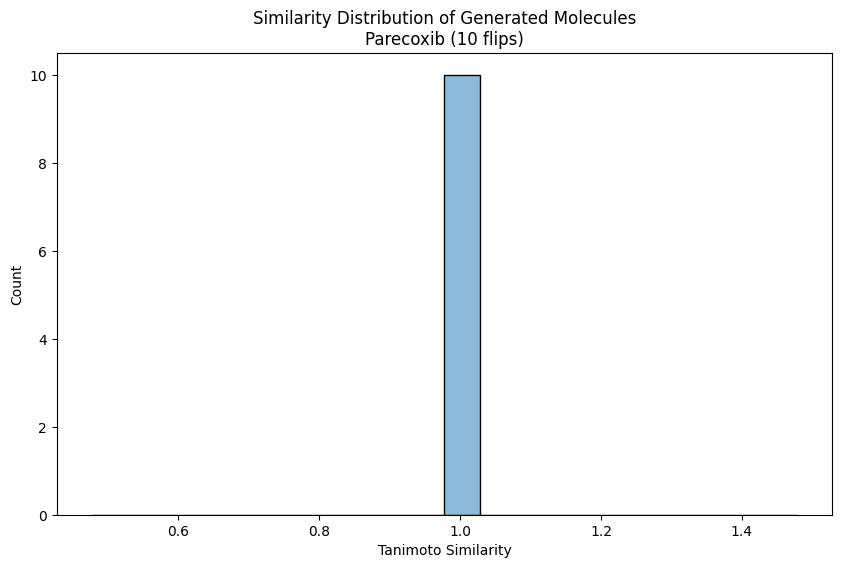

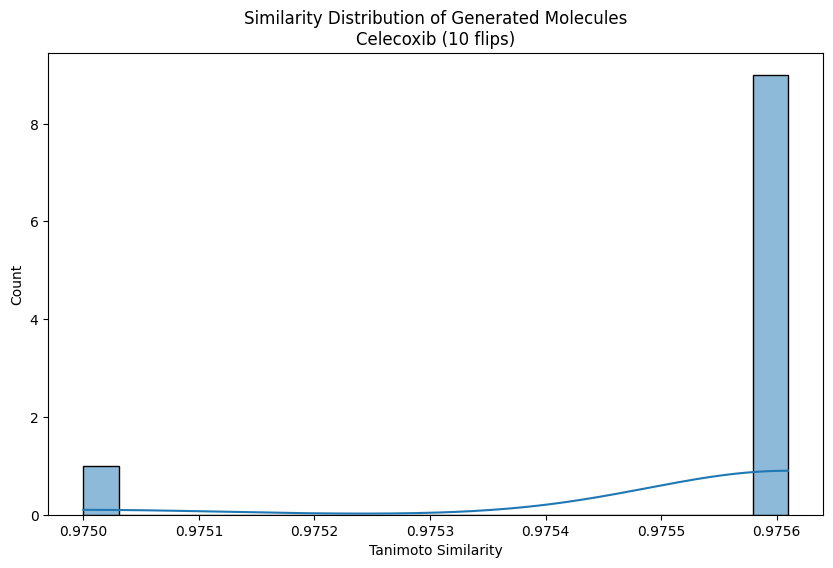

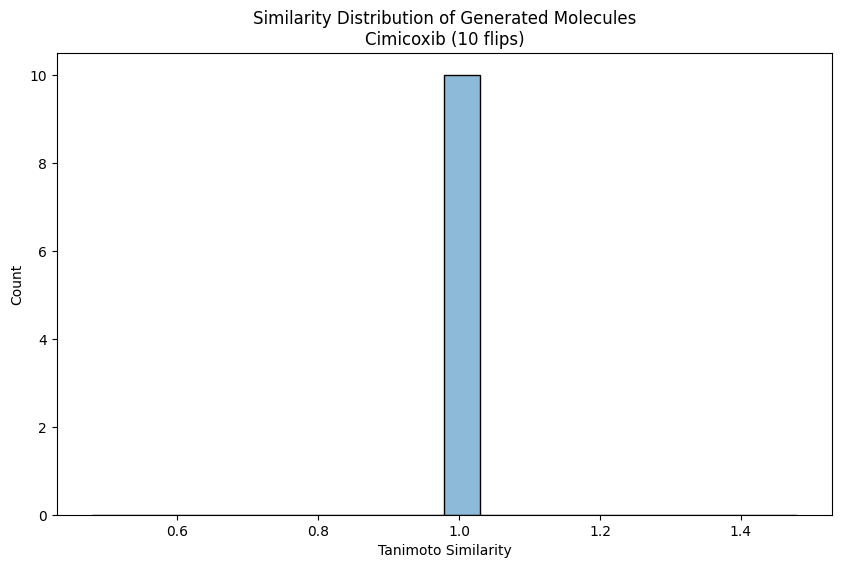

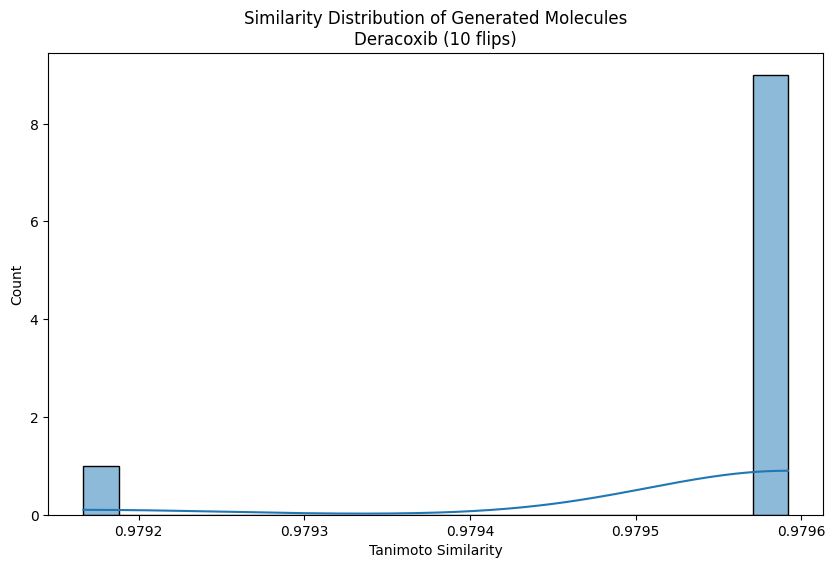

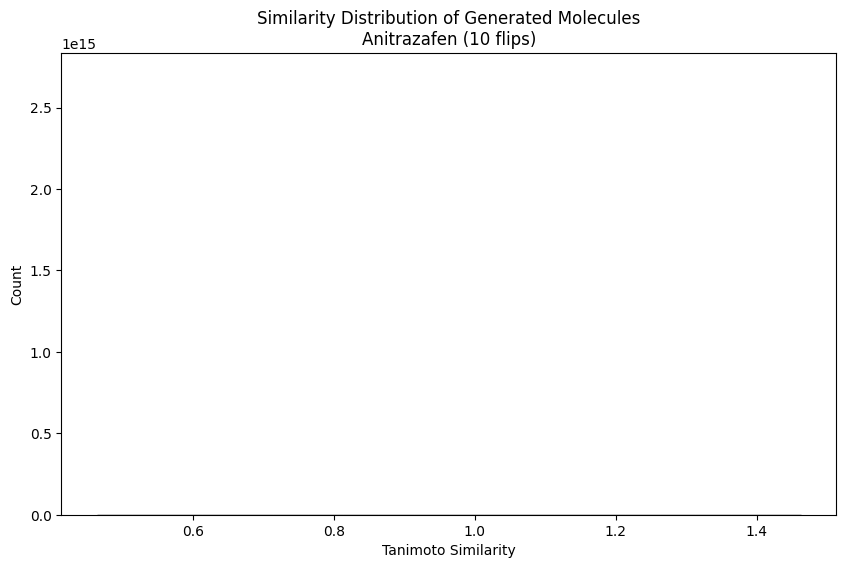

In [16]:
plot_similarity_distribution(parecoxib_df_10, 'Parecoxib', 10)
plot_similarity_distribution(celecoxib_df_10, 'Celecoxib', 10)
plot_similarity_distribution(cimicoxib_df_10, 'Cimicoxib', 10)
plot_similarity_distribution(deracoxib_df_10, 'Deracoxib', 10)
plot_similarity_distribution(anitrazafen_df_10, 'Anitrazafen', 10)

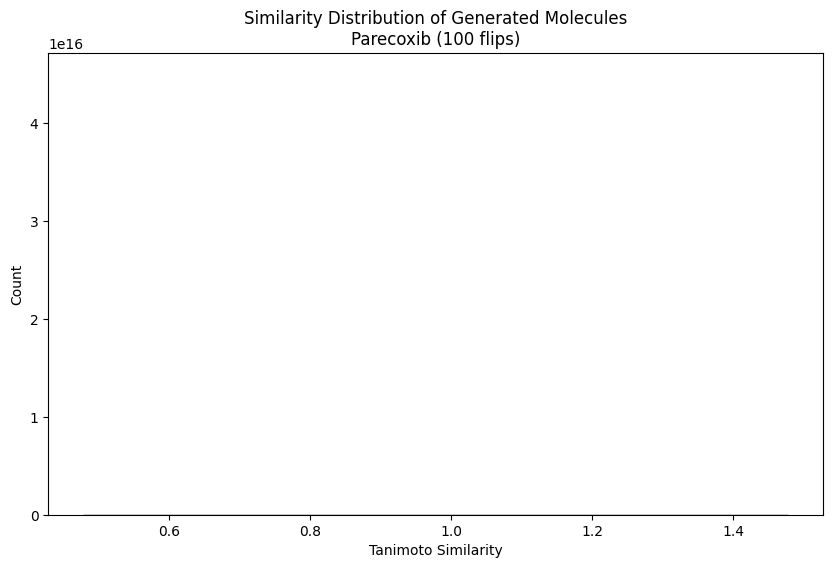

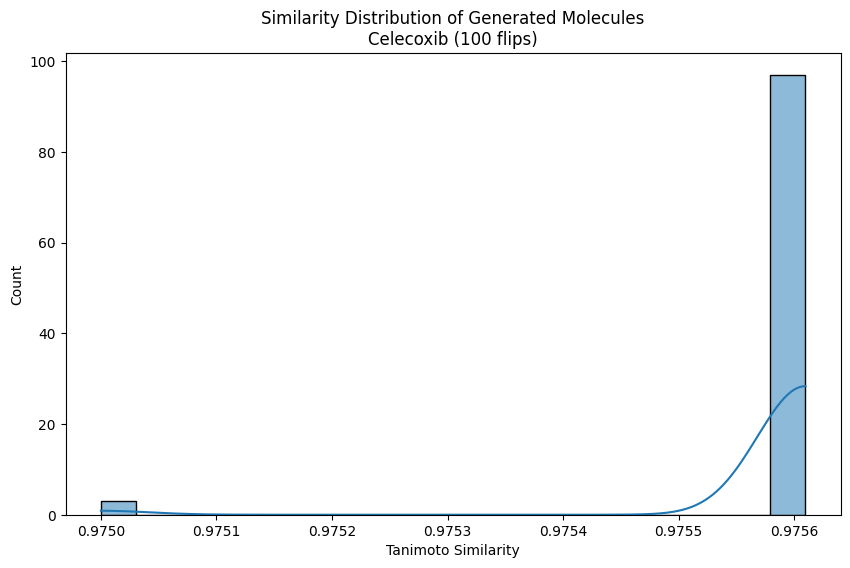

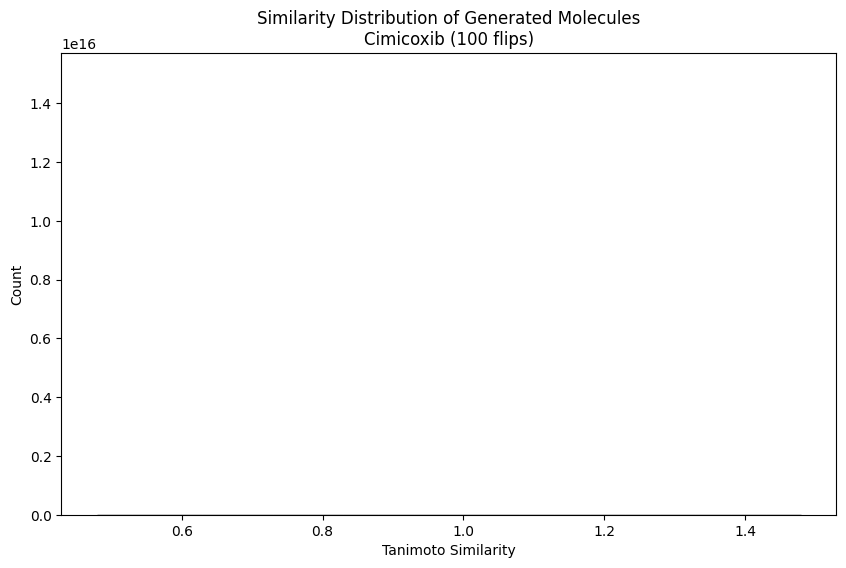

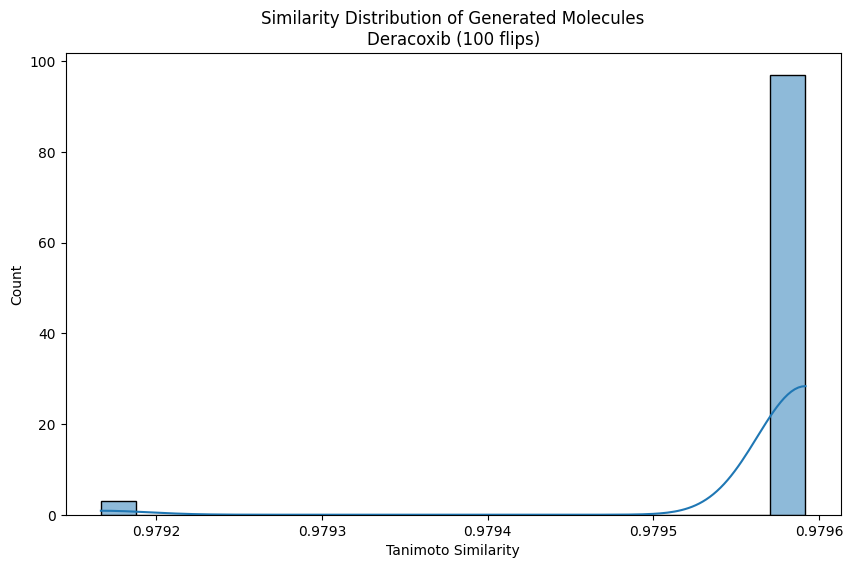

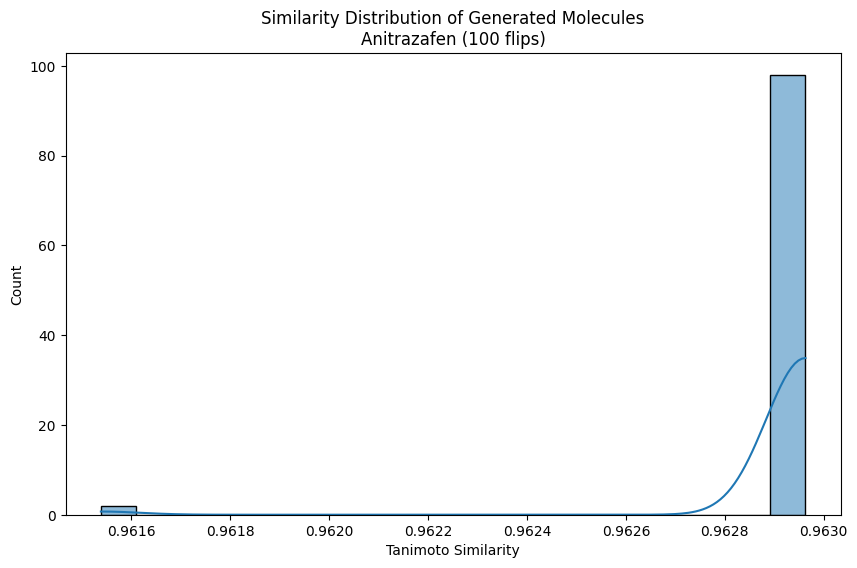

In [17]:
plot_similarity_distribution(parecoxib_df_100, 'Parecoxib', 100)
plot_similarity_distribution(celecoxib_df_100, 'Celecoxib', 100)
plot_similarity_distribution(cimicoxib_df_100, 'Cimicoxib', 100)
plot_similarity_distribution(deracoxib_df_100, 'Deracoxib', 100)
plot_similarity_distribution(anitrazafen_df_100, 'Anitrazafen', 100)

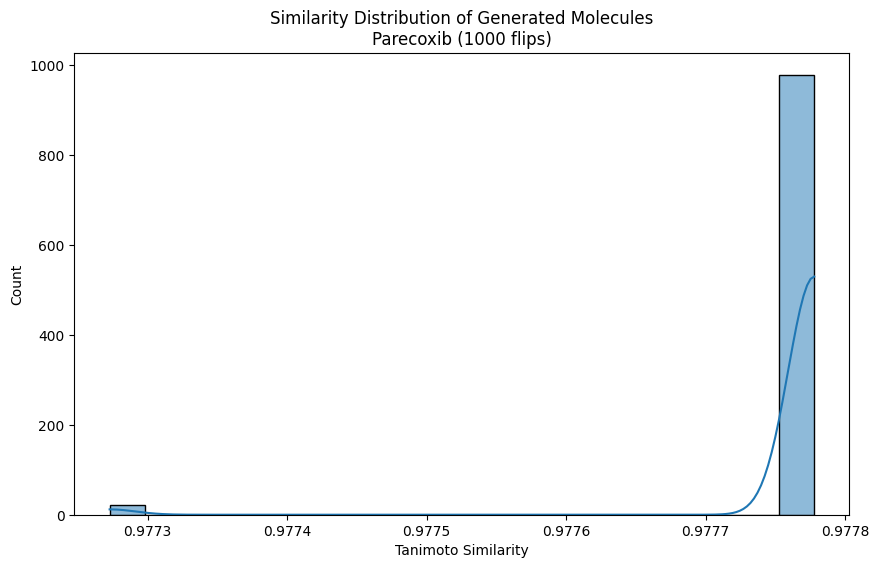

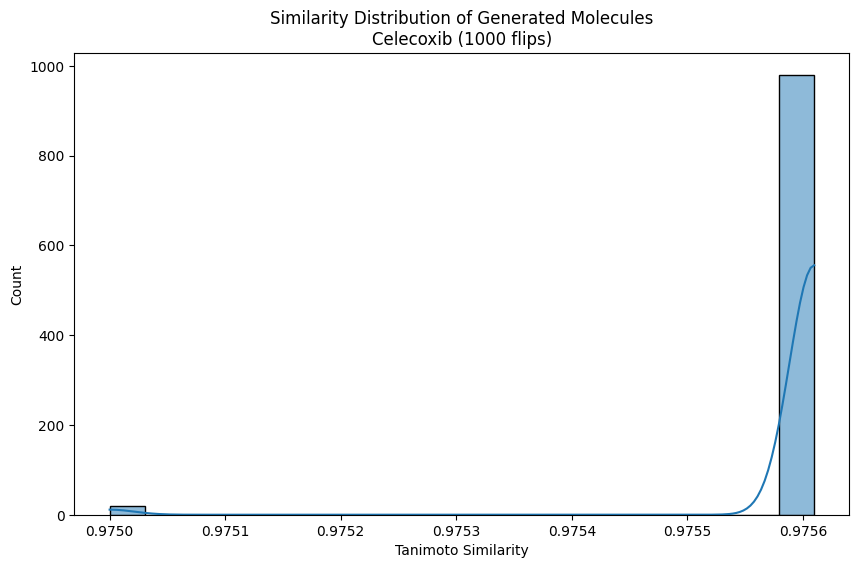

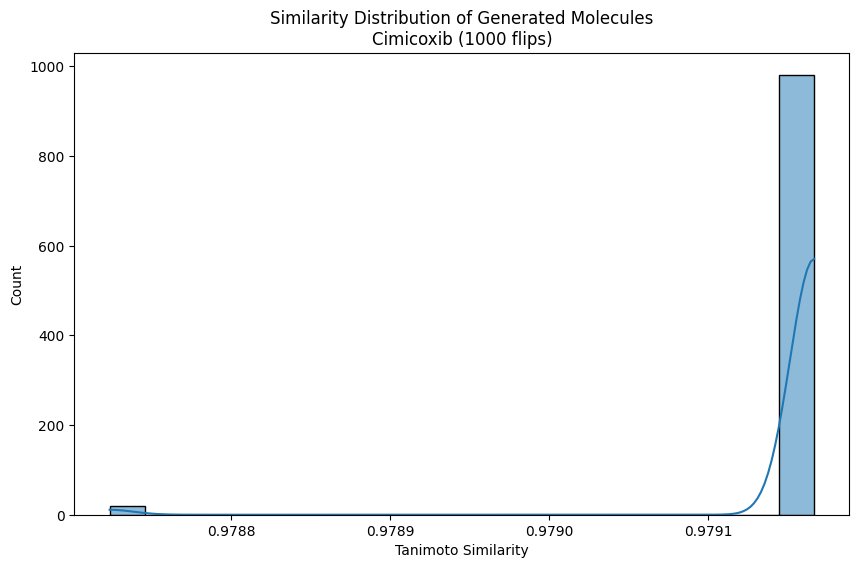

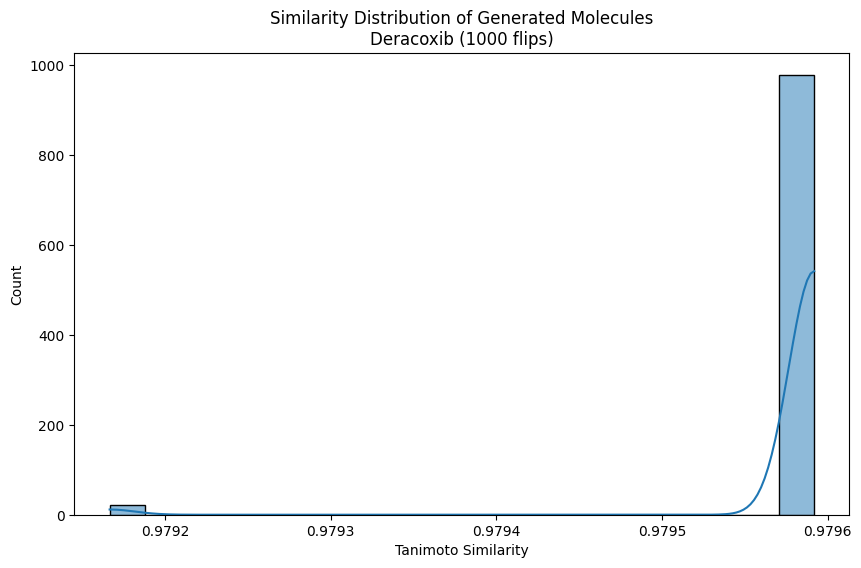

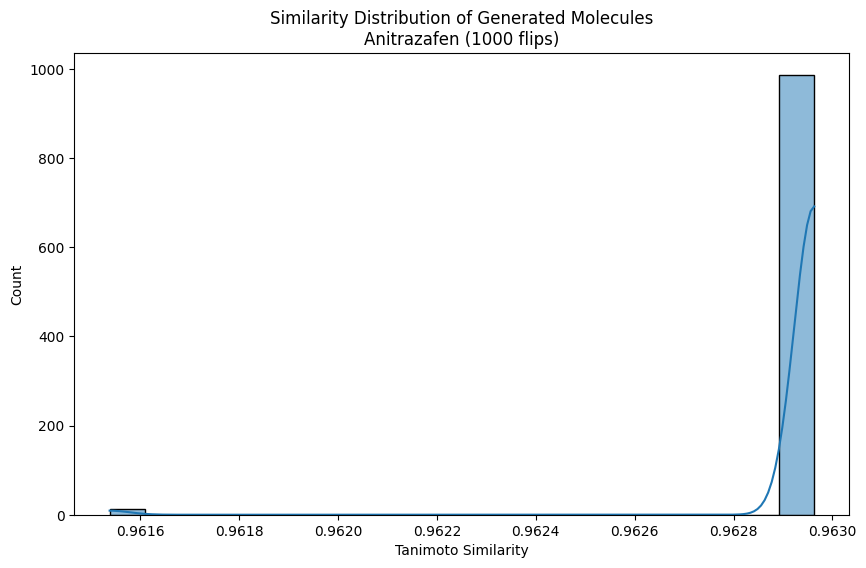

In [18]:
plot_similarity_distribution(parecoxib_df_1000, 'Parecoxib', 1000)
plot_similarity_distribution(celecoxib_df_1000, 'Celecoxib', 1000)
plot_similarity_distribution(cimicoxib_df_1000, 'Cimicoxib', 1000)
plot_similarity_distribution(deracoxib_df_1000, 'Deracoxib', 1000)
plot_similarity_distribution(anitrazafen_df_1000, 'Anitrazafen', 1000)

### Compare generated SMILES
***

In [19]:
def analyze_smiles_occurrences(df_10, df_100, df_1000, compound_name):
    # Get value counts for each dataset
    smiles_counts_10 = df_10['Generated_SMILES'].value_counts().to_dict()
    smiles_counts_100 = df_100['Generated_SMILES'].value_counts().to_dict()
    smiles_counts_1000 = df_1000['Generated_SMILES'].value_counts().to_dict()
    
    # Create result dictionary
    results = {
        'compound_name': compound_name,
        'datasets': {
            '10_flips': {
                'occurrences': smiles_counts_10,
                'total_unique': len(smiles_counts_10),
                'total_samples': len(df_10)
            },
            '100_flips': {
                'occurrences': smiles_counts_100,
                'total_unique': len(smiles_counts_100),
                'total_samples': len(df_100)
            },
            '1000_flips': {
                'occurrences': smiles_counts_1000,
                'total_unique': len(smiles_counts_1000),
                'total_samples': len(df_1000)
            }
        }
    }
    
    return results

def print_smiles_analysis(results):
    compound_name = results['compound_name']
    print(f"\n**** {compound_name} ****")
    
    for dataset_name, dataset_info in results['datasets'].items():
        print(f"\n--- {dataset_name} ---")
        print(f"Total unique SMILES: {dataset_info['total_unique']}")
        print(f"Total samples: {dataset_info['total_samples']}")
        print("SMILES occurrences:")
        
        # Sort by occurrence count (descending) and print
        sorted_smiles = sorted(dataset_info['occurrences'].items(), key=lambda x: (-x[1], x[0]))
        
        for smiles, count in sorted_smiles:
            print(f"Count: {count} - SMILES: {smiles}")

In [20]:
parecoxib_results = analyze_smiles_occurrences(parecoxib_df_10, parecoxib_df_100, parecoxib_df_1000, "Parecoxib")
celecoxib_results = analyze_smiles_occurrences(celecoxib_df_10, celecoxib_df_100, celecoxib_df_1000, "Celecoxib")
cimicoxib_results = analyze_smiles_occurrences(cimicoxib_df_10, cimicoxib_df_100, cimicoxib_df_1000, "Cimicoxib")
deracoxib_results = analyze_smiles_occurrences(deracoxib_df_10, deracoxib_df_100, deracoxib_df_1000, "Deracoxib")
anitrazafen_results = analyze_smiles_occurrences(anitrazafen_df_10, anitrazafen_df_100, anitrazafen_df_1000, "Anitrazafen")

print_smiles_analysis(anitrazafen_results)


**** Anitrazafen ****

--- 10_flips ---
Total unique SMILES: 1
Total samples: 10
SMILES occurrences:
Count: 10 - SMILES: COc1ccc(-c2nnc(C)nc2-c2ccc(OC)cc2)cc1

--- 100_flips ---
Total unique SMILES: 2
Total samples: 100
SMILES occurrences:
Count: 99 - SMILES: COc1ccc(-c2nnc(C)nc2-c2ccc(OC)cc2)cc1
Count: 1 - SMILES: COc1ccc(-c2nnc(C)nc2-c2ccc(-c3nnc(C)nc3-c3ccc(OC)cc3)cc2)cc1

--- 1000_flips ---
Total unique SMILES: 11
Total samples: 1000
SMILES occurrences:
Count: 989 - SMILES: COc1ccc(-c2nnc(C)nc2-c2ccc(OC)cc2)cc1
Count: 2 - SMILES: COc1ccc(-c2nnc(-c3ccc(OC)cc3)c3nc(C)nnc23)cc1
Count: 1 - SMILES: COC1=NC(c2ccc(OC)cc2)=C(c2ccc(OC)cc2)N=C(C)N1
Count: 1 - SMILES: COc1ccc(-c2nc(C)nc3nc(C)nnc23)cc1
Count: 1 - SMILES: COc1ccc(-c2nc(C)nnc2C)cc1
Count: 1 - SMILES: COc1ccc(-c2nc3nnc(C)nc3nc2-c2ccc(OC)cc2)cc1
Count: 1 - SMILES: COc1ccc(-c2nnc(-c3ccc(OC)cc3)c3c(-c4ccc(OC)cc4)nc(C)nc23)cc1
Count: 1 - SMILES: COc1ccc(-c2nnc(C)nc2-c2ccc(-c3nnc(C)nc3-c3ccc(OC)cc3)cc2)cc1
Count: 1 - SMILES: COc1ccc(

### Plot generated molecules
***

In [21]:
def mol_to_image(mol):
    if isinstance(mol, str):
        mol = Chem.MolFromSmiles(mol)
    if mol is None:
        return None
    img = Draw.MolToImage(mol)
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode()

def plot_unique_molecules(df, n_flips):
    molecule_name = df.iloc[0]['title'].lower()
    
    # Create a new column in df to store the original index
    df['original_index'] = df.index

    # Remove duplicates based on 'Generated_SMILES' but keep original indices
    df_unique = df.drop_duplicates(subset=['Generated_SMILES']).copy()
    
    n_rows = len(df_unique) + 1  # +1 for the original molecule
    fig, axes = plt.subplots(n_rows, 1, figsize=(10, 5*n_rows))
    
    # Plot original molecule
    original_mol = Chem.MolFromSmiles(df.iloc[0]['SMILES'])
    img = Draw.MolToImage(original_mol)
    axes[0].imshow(img)
    axes[0].set_title(f"Original Molecule: {df.iloc[0]['title']}\nSMILES: {df.iloc[0]['SMILES']}")
    axes[0].axis('off')
    
    # Plot unique generated molecules
    for i, row in enumerate(df_unique.iterrows(), start=1):
        img = mol_to_image(row[1]['Generated_SMILES'])
        if img:
            axes[i].imshow(Image.open(io.BytesIO(base64.b64decode(img))))
            axes[i].set_title(f"Generated Molecule {i} (Flipped Bits: {row[1]['FlippedBitPosition']})\n"
                              f"SMILES: {row[1]['Generated_SMILES']}\n"
                              f"Tanimoto = {row[1].get('Tanimoto', 'N/A'):.2f}\n"
                              f"Original Index: {row[1]['original_index']}")
        else:
            axes[i].text(0.5, 0.5, "Invalid SMILES", ha='center', va='center')
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(INPUT_DIR, f'{molecule_name}_{n_flips}_unique_flips.png'))
    plt.close(fig)

In [52]:
plot_unique_molecules(parecoxib_df_10,10)
plot_unique_molecules(celecoxib_df_10,10)
plot_unique_molecules(cimicoxib_df_10,10)
plot_unique_molecules(deracoxib_df_10,10)
plot_unique_molecules(anitrazafen_df_10,10)

plot_unique_molecules(parecoxib_df_100,100)
plot_unique_molecules(celecoxib_df_100,100)
plot_unique_molecules(cimicoxib_df_100,100)
plot_unique_molecules(deracoxib_df_100,100)
plot_unique_molecules(anitrazafen_df_100,100)

plot_unique_molecules(parecoxib_df_1000,1000)
plot_unique_molecules(celecoxib_df_1000,1000)
plot_unique_molecules(cimicoxib_df_1000,1000)
plot_unique_molecules(deracoxib_df_1000,1000)
plot_unique_molecules(anitrazafen_df_1000,1000)

### Plot the nearest neighbors
***

In [22]:
def calculate_fingerprint_similarity_matrix(original_bits, flipped_bits):
    """Calculate similarity matrix comparing original and flipped fingerprint bits."""
    all_bits = [original_bits] + flipped_bits
    n = len(all_bits)
    similarity_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            # Convert bit strings to numpy arrays for comparison
            bits_i = np.array([int(b) for b in all_bits[i]])
            bits_j = np.array([int(b) for b in all_bits[j]])
            
            # Calculate Tanimoto similarity directly from bit vectors
            intersection = np.sum(np.logical_and(bits_i, bits_j))
            union = np.sum(np.logical_or(bits_i, bits_j))
            similarity_matrix[i, j] = intersection / union if union > 0 else 0
            
    return similarity_matrix

def plot_mds_similarity(df, title_column='title', n_flips=10):
    """Plot MDS similarity using original and flipped fingerprint bits."""
    if df.empty:
        print(f"Warning: Empty DataFrame for {title_column}")
        return
        
    try:
        # Store original index
        if 'original_index' not in df.columns:
            df['original_index'] = df.index

        # Get original and flipped fingerprint bits
        original_bits = df['FingerprintBits'].iloc[0]
        flipped_bits = df['FingerprintBitsFlipped'].tolist()
        
        if not flipped_bits:
            print(f"Warning: No flipped bits found for {df[title_column].iloc[0]}")
            return
            
        # Calculate similarity matrix
        similarity_matrix = calculate_fingerprint_similarity_matrix(original_bits, flipped_bits)

        # Apply MDS
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        coords = mds.fit_transform(1 - similarity_matrix)

        # Calculate similarities to original fingerprint
        similarities_to_original = similarity_matrix[0, 1:]

        # Create plot
        plt.figure(figsize=(14, 10))
        
        # Plot flipped fingerprints
        scatter = plt.scatter(coords[1:, 0], coords[1:, 1], 
                            c=similarities_to_original, 
                            cmap='viridis', 
                            alpha=0.6, 
                            s=100)
        
        # Plot original fingerprint
        plt.scatter(coords[0, 0], coords[0, 1], 
                   c='red', 
                   s=200, 
                   label='Original', 
                   edgecolors='black')

        # Add color bar and labels
        cbar = plt.colorbar(scatter)
        cbar.set_label('Tanimoto Similarity to Original', rotation=270, labelpad=20)

        for i in range(len(coords)):
            label = "Original" if i == 0 else f"{df['original_index'].iloc[i-1]}"
            plt.annotate(label, 
                        (coords[i, 0], coords[i, 1]), 
                        xytext=(5, 5),
                        textcoords='offset points', 
                        fontsize=8)

        plt.title(f"2D Projection of Fingerprint Bit Similarity for {df[title_column].iloc[0]} ({n_flips} flips)")
        plt.xlabel("MDS Dimension 1")
        plt.ylabel("MDS Dimension 2")
        plt.legend()
        plt.tight_layout()
        
        filename = f'{df[title_column].iloc[0].lower()}_{n_flips}_flips_mds_similarity.png'
        plt.savefig(os.path.join(INPUT_DIR, filename))
        plt.close()
        
        return True
        
    except Exception as e:
        print(f"Error processing {df[title_column].iloc[0] if not df.empty else 'unknown'}: {str(e)}")
        plt.close()
        return False
    
def process_and_plot(df, n_flips):
    """Process dataframe and generate plot with error handling."""
    try:
        success = plot_mds_similarity(df, n_flips=n_flips)
        if success:
            print(f"MDS plot saved for {df['title'].iloc[0]} with {n_flips} flips.")
        else:
            print(f"Failed to create MDS plot for data with {n_flips} flips.")
    except Exception as e:
        print(f"Error in process_and_plot with {n_flips} flips: {str(e)}")

In [54]:
process_and_plot(parecoxib_df_10, 10)
process_and_plot(celecoxib_df_10, 10)
process_and_plot(cimicoxib_df_10, 10)
process_and_plot(deracoxib_df_10, 10)
process_and_plot(anitrazafen_df_10, 10)

process_and_plot(parecoxib_df_100, 100)
process_and_plot(celecoxib_df_100, 100)
process_and_plot(cimicoxib_df_100, 100)
process_and_plot(deracoxib_df_100, 100)
process_and_plot(anitrazafen_df_100, 100)

process_and_plot(parecoxib_df_1000, 1000)
process_and_plot(celecoxib_df_1000, 1000)
process_and_plot(cimicoxib_df_1000, 1000)
process_and_plot(deracoxib_df_1000, 1000)
process_and_plot(anitrazafen_df_1000, 1000)

MDS plot saved for Parecoxib with 10 flips.
MDS plot saved for Celecoxib with 10 flips.
MDS plot saved for Cimicoxib with 10 flips.
MDS plot saved for Deracoxib with 10 flips.
MDS plot saved for Anitrazafen with 10 flips.
MDS plot saved for Parecoxib with 100 flips.
MDS plot saved for Celecoxib with 100 flips.
MDS plot saved for Cimicoxib with 100 flips.
MDS plot saved for Deracoxib with 100 flips.
MDS plot saved for Anitrazafen with 100 flips.
MDS plot saved for Parecoxib with 1000 flips.
MDS plot saved for Celecoxib with 1000 flips.
MDS plot saved for Cimicoxib with 1000 flips.
MDS plot saved for Deracoxib with 1000 flips.
MDS plot saved for Anitrazafen with 1000 flips.


In [23]:
def plot_tsne_similarity(df, title_column='title', n_flips=10):
    """Plot t-SNE similarity using original and flipped fingerprint bits."""
    if df.empty:
        print(f"Warning: Empty DataFrame for {title_column}")
        return False
        
    try:
        # Store original index
        if 'original_index' not in df.columns:
            df['original_index'] = df.index

        # Get original and flipped fingerprint bits
        original_bits = df['FingerprintBits'].iloc[0]
        flipped_bits = df['FingerprintBitsFlipped'].tolist()
        
        if not flipped_bits:
            print(f"Warning: No flipped bits found for {df[title_column].iloc[0]}")
            return False
            
        # Calculate similarity matrix using the same method as MDS
        similarity_matrix = calculate_fingerprint_similarity_matrix(original_bits, flipped_bits)

        # Adjust perplexity based on number of samples
        n_samples = len(flipped_bits) + 1  # +1 for original
        perplexity = min(30, max(5, n_samples - 1))
        
        # Apply t-SNE
        try:
            tsne = TSNE(n_components=2, 
                       metric='precomputed', 
                       random_state=42,
                       perplexity=perplexity, 
                       init='random', 
                       learning_rate='auto')
            coords = tsne.fit_transform(1 - similarity_matrix)
        except ValueError as e:
            print(f"t-SNE error for {df[title_column].iloc[0]}: {str(e)}")
            return False

        # Calculate similarities to original fingerprint
        similarities_to_original = similarity_matrix[0, 1:]

        # Create plot
        plt.figure(figsize=(14, 10))
        
        # Plot flipped fingerprints
        scatter = plt.scatter(coords[1:, 0], coords[1:, 1], 
                            c=similarities_to_original, 
                            cmap='viridis', 
                            alpha=0.6, 
                            s=100)
        
        # Plot original fingerprint
        plt.scatter(coords[0, 0], coords[0, 1], 
                   c='red', 
                   s=200, 
                   label='Original', 
                   edgecolors='black')

        # Add color bar and labels
        cbar = plt.colorbar(scatter)
        cbar.set_label('Tanimoto Similarity to Original', rotation=270, labelpad=20)

        for i in range(len(coords)):
            label = "Original" if i == 0 else f"{df['original_index'].iloc[i-1]}"
            plt.annotate(label, 
                        (coords[i, 0], coords[i, 1]), 
                        xytext=(5, 5),
                        textcoords='offset points', 
                        fontsize=8)

        plt.title(f"2D Projection of Fingerprint Bit Similarity for {df[title_column].iloc[0]} ({n_flips} flips)")
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.legend()
        plt.tight_layout()
        
        filename = f'{df[title_column].iloc[0].lower()}_{n_flips}_flips_tsne_similarity.png'
        plt.savefig(os.path.join(INPUT_DIR, filename))
        plt.close()
        
        return True
        
    except Exception as e:
        print(f"Error processing {df[title_column].iloc[0] if not df.empty else 'unknown'}: {str(e)}")
        plt.close()
        return False

def process_and_plot_tsne(df, n_flips):
    """Process dataframe and generate t-SNE plot with error handling."""
    try:
        success = plot_tsne_similarity(df, n_flips=n_flips)
        if success:
            print(f"t-SNE plot saved for {df['title'].iloc[0]} with {n_flips} flips.")
        else:
            print(f"Failed to create t-SNE plot for data with {n_flips} flips.")
    except Exception as e:
        print(f"Error in process_and_plot_tsne with {n_flips} flips: {str(e)}")

In [56]:
process_and_plot_tsne(parecoxib_df_10, 10)
process_and_plot_tsne(celecoxib_df_10, 10)
process_and_plot_tsne(cimicoxib_df_10, 10)
process_and_plot_tsne(deracoxib_df_10, 10)
process_and_plot_tsne(anitrazafen_df_10, 10)

process_and_plot_tsne(parecoxib_df_100, 100)
process_and_plot_tsne(celecoxib_df_100, 100)
process_and_plot_tsne(cimicoxib_df_100, 100)
process_and_plot_tsne(deracoxib_df_100, 100)
process_and_plot_tsne(anitrazafen_df_100, 100)

process_and_plot_tsne(parecoxib_df_1000, 1000)
process_and_plot_tsne(celecoxib_df_1000, 1000)
process_and_plot_tsne(cimicoxib_df_1000, 1000)
process_and_plot_tsne(deracoxib_df_1000, 1000)
process_and_plot_tsne(anitrazafen_df_1000, 1000)

t-SNE plot saved for Parecoxib with 10 flips.
t-SNE plot saved for Celecoxib with 10 flips.
t-SNE plot saved for Cimicoxib with 10 flips.
t-SNE plot saved for Deracoxib with 10 flips.
t-SNE plot saved for Anitrazafen with 10 flips.
t-SNE plot saved for Parecoxib with 100 flips.
t-SNE plot saved for Celecoxib with 100 flips.
t-SNE plot saved for Cimicoxib with 100 flips.
t-SNE plot saved for Deracoxib with 100 flips.
t-SNE plot saved for Anitrazafen with 100 flips.
t-SNE plot saved for Parecoxib with 1000 flips.
t-SNE plot saved for Celecoxib with 1000 flips.
t-SNE plot saved for Cimicoxib with 1000 flips.
t-SNE plot saved for Deracoxib with 1000 flips.
t-SNE plot saved for Anitrazafen with 1000 flips.


### Bits Analysis

In [24]:
dataframes_dict = {
    'parecoxib': {
        10: parecoxib_df_10,
        100: parecoxib_df_100,
        1000: parecoxib_df_1000
    },
    'celecoxib': {
        10: celecoxib_df_10,
        100: celecoxib_df_100,
        1000: celecoxib_df_1000
    },
    'cimicoxib': {
        10: cimicoxib_df_10,
        100: cimicoxib_df_100,
        1000: cimicoxib_df_1000
    },
    'deracoxib': {
        10: deracoxib_df_10,
        100: deracoxib_df_100,
        1000: deracoxib_df_1000
    },
    'anitrazafen': {
        10: anitrazafen_df_10,
        100: anitrazafen_df_100,
        1000: anitrazafen_df_1000
    }
}

In [28]:
def analyze_bit_similarities(df, molecule_name, n_flips):
    """
    Analyze similarities for each bit position and create detailed summary
    """
    bit_analysis = defaultdict(lambda: {
        'similarities': [],
        'count': 0,
        'avg_similarity': 0,
        'std_similarity': 0,
        'min_similarity': 1,
        'max_similarity': 0,
        'molecule': molecule_name,
        'n_flips': n_flips
    })
    
    # Get original molecule for structure analysis
    original_smiles = df['SMILES'].iloc[0]
    mol = Chem.MolFromSmiles(original_smiles)
    info = {}
    # Generate Morgan fingerprint and get bit info
    AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048, bitInfo=info)
    
    # Analyze each bit flip
    for idx, row in df.iterrows():
        bit = row['FlippedBitPosition']
        similarity = row['Tanimoto']
        
        bit_analysis[bit]['similarities'].append(similarity)
        bit_analysis[bit]['count'] += 1
        bit_analysis[bit]['min_similarity'] = min(bit_analysis[bit]['min_similarity'], similarity)
        bit_analysis[bit]['max_similarity'] = max(bit_analysis[bit]['max_similarity'], similarity)
        
        # Add structural information if available
        if bit in info:
            bit_analysis[bit]['substructures'] = info[bit]
    
    # Calculate statistics
    for bit, data in bit_analysis.items():
        similarities = data['similarities']
        data['avg_similarity'] = np.mean(similarities)
        data['std_similarity'] = np.std(similarities) if len(similarities) > 1 else 0
    
    return bit_analysis

def generate_bit_impact_report(dataframes_dict):
    """
    Generate comprehensive report comparing bit impacts across molecules and flip counts
    """
    all_analyses = {}
    summary_stats = []
    
    # Analyze each molecule and flip count combination
    for molecule, flip_dict in dataframes_dict.items():
        for n_flips, df in flip_dict.items():
            try:
                analysis = analyze_bit_similarities(df, molecule, n_flips)
                key = f"{molecule}_{n_flips}"
                all_analyses[key] = analysis
                
                # Create DataFrame for this analysis
                analysis_df = pd.DataFrame([{
                    'Molecule': molecule,
                    'N_Flips': n_flips,
                    'Bit_Position': bit,
                    'Average_Similarity': data['avg_similarity'],
                    'Std_Similarity': data['std_similarity'],
                    'Min_Similarity': data['min_similarity'],
                    'Max_Similarity': data['max_similarity'],
                    'Times_Flipped': data['count'],
                    'Has_Structural_Info': 'Yes' if 'substructures' in data else 'No',
                    'Structural_Info': str(data.get('substructures', ''))
                } for bit, data in analysis.items()])
                
                # Get summary statistics
                top_bits = analysis_df.nsmallest(10, 'Average_Similarity')
                bottom_bits = analysis_df.nlargest(10, 'Average_Similarity')
                
                summary_stats.append({
                    'Molecule': molecule,
                    'N_Flips': n_flips,
                    'Most_Impactful_Bits': top_bits['Bit_Position'].tolist(),
                    'Least_Impactful_Bits': bottom_bits['Bit_Position'].tolist(),
                    'Avg_Similarity': analysis_df['Average_Similarity'].mean(),
                    'Std_Similarity': analysis_df['Average_Similarity'].std()
                })
            except Exception as e:
                print(f"Error processing {molecule} with {n_flips} flips: {str(e)}")
                continue
    
    summary_df = pd.DataFrame(summary_stats)
    return all_analyses, summary_df

def analyze_single_molecule(dataframes_dict, molecule_name, n_flips):
    """
    Detailed analysis of a single molecule's fingerprint bits
    """
    df = dataframes_dict[molecule_name.lower()][n_flips]
    analysis = analyze_bit_similarities(df, molecule_name, n_flips)
    
    # Get original molecule
    original_smiles = df['SMILES'].iloc[0]
    mol = Chem.MolFromSmiles(original_smiles)
    
    # Calculate Morgan fingerprint and get bit info
    info = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048, bitInfo=info)
    
    # Sort bits by impact
    sorted_bits = sorted(
        analysis.items(), 
        key=lambda x: x[1]['avg_similarity']
    )[:10]  # Get top 10 most impactful bits
    
    # Display molecule information
    print(f"Analysis for {molecule_name} ({n_flips} flips):")
    print(f"SMILES: {original_smiles}\n")
    display(Draw.MolToImage(mol))
    print("\nTop 10 Most Impactful Bits:")
    
    # Separate bits with and without structural information
    bits_with_info = []
    bits_without_info = []
    
    for bit, data in sorted_bits:
        if bit in info:
            bits_with_info.append((bit, data))
        else:
            bits_without_info.append((bit, data))
    
    # Display bits with structural information
    if bits_with_info:
        print("\nBits with structural information:")
        for bit, data in bits_with_info:
            print(f"\nBit {bit}:")
            print(f"Tanimoto Similarity: {data['avg_similarity']:.4f}")
            print(f"Times Flipped: {data['count']}")
            display(Draw.DrawMorganBit(mol, bit, info))
    
    # Display bits without structural information
    if bits_without_info:
        print("\nBits without structural information:")
        print(", ".join([f"Bit {bit} (Tanimoto: {data['avg_similarity']:.4f})" 
                        for bit, data in bits_without_info]))

Analysis for celecoxib (1000 flips):
SMILES: Cc1ccc(cc1)c2cc(nn2c3ccc(cc3)S(=O)(=O)N)C(F)(F)F



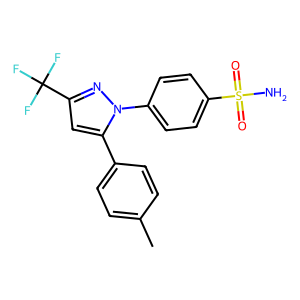


Top 10 Most Impactful Bits:

Bits with structural information:

Bit 753:
Tanimoto Similarity: 0.9750
Times Flipped: 1


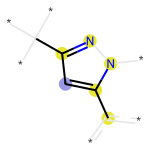


Bit 1920:
Tanimoto Similarity: 0.9750
Times Flipped: 1


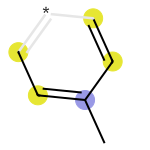


Bit 1956:
Tanimoto Similarity: 0.9750
Times Flipped: 1


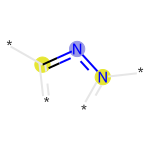


Bit 1476:
Tanimoto Similarity: 0.9750
Times Flipped: 1


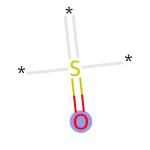


Bit 1328:
Tanimoto Similarity: 0.9750
Times Flipped: 1


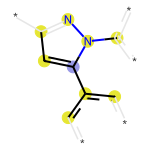


Bit 235:
Tanimoto Similarity: 0.9750
Times Flipped: 1


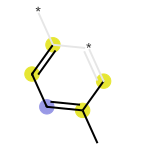


Bit 1928:
Tanimoto Similarity: 0.9750
Times Flipped: 1


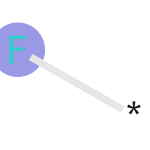


Bit 1607:
Tanimoto Similarity: 0.9750
Times Flipped: 1


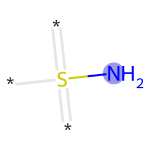


Bit 896:
Tanimoto Similarity: 0.9750
Times Flipped: 1


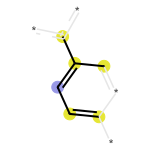


Bit 233:
Tanimoto Similarity: 0.9750
Times Flipped: 1


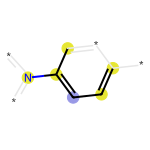



Analysis for cimicoxib (1000 flips):
SMILES: COc1ccc(cc1F)c2c(Cl)ncn2c3ccc(cc3)S(=O)(=O)N



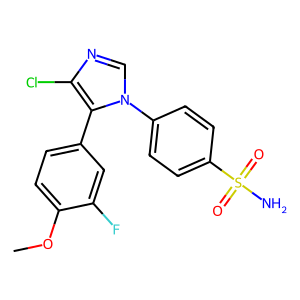


Top 10 Most Impactful Bits:

Bits with structural information:

Bit 1607:
Tanimoto Similarity: 0.9787
Times Flipped: 1


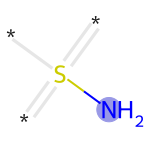


Bit 875:
Tanimoto Similarity: 0.9787
Times Flipped: 1


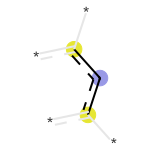


Bit 249:
Tanimoto Similarity: 0.9787
Times Flipped: 1


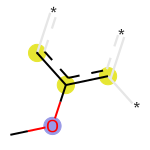


Bit 1970:
Tanimoto Similarity: 0.9787
Times Flipped: 1


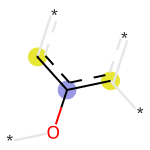


Bit 1057:
Tanimoto Similarity: 0.9787
Times Flipped: 1


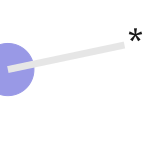


Bit 1683:
Tanimoto Similarity: 0.9787
Times Flipped: 1


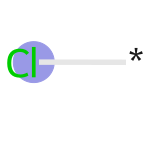


Bit 1476:
Tanimoto Similarity: 0.9787
Times Flipped: 1


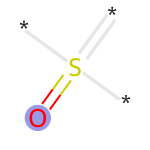


Bit 1489:
Tanimoto Similarity: 0.9787
Times Flipped: 1


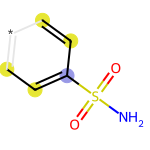


Bit 233:
Tanimoto Similarity: 0.9787
Times Flipped: 1


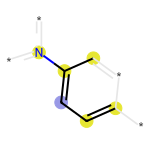


Bit 935:
Tanimoto Similarity: 0.9787
Times Flipped: 1


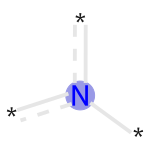



Analysis for deracoxib (1000 flips):
SMILES: COc1ccc(cc1F)c2cc(nn2c3ccc(cc3)S(=O)(=O)N)C(F)F



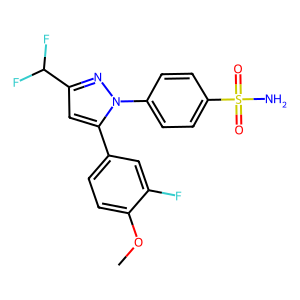


Top 10 Most Impactful Bits:

Bits with structural information:

Bit 378:
Tanimoto Similarity: 0.9792
Times Flipped: 1


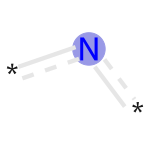


Bit 1928:
Tanimoto Similarity: 0.9792
Times Flipped: 1


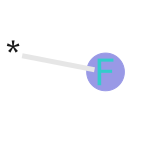


Bit 875:
Tanimoto Similarity: 0.9792
Times Flipped: 1


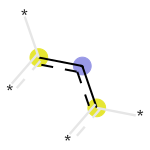


Bit 1956:
Tanimoto Similarity: 0.9792
Times Flipped: 1


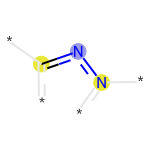


Bit 1:
Tanimoto Similarity: 0.9792
Times Flipped: 1


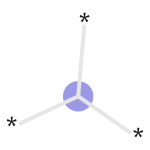


Bit 233:
Tanimoto Similarity: 0.9792
Times Flipped: 1


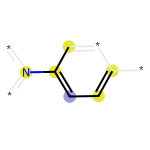


Bit 1852:
Tanimoto Similarity: 0.9792
Times Flipped: 1


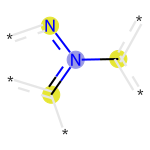


Bit 833:
Tanimoto Similarity: 0.9792
Times Flipped: 1


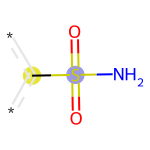


Bit 1780:
Tanimoto Similarity: 0.9792
Times Flipped: 1


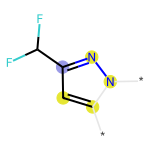


Bit 1607:
Tanimoto Similarity: 0.9792
Times Flipped: 1


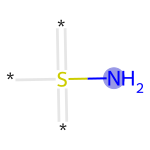



Analysis for parecoxib (1000 flips):
SMILES: CCC(=O)NS(=O)(=O)c1ccc(cc1)c2c(C)onc2c3ccccc3



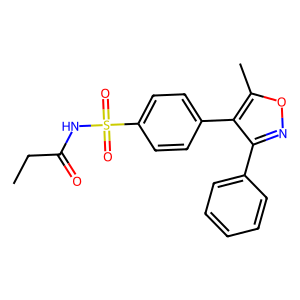


Top 10 Most Impactful Bits:

Bits with structural information:

Bit 502:
Tanimoto Similarity: 0.9773
Times Flipped: 1


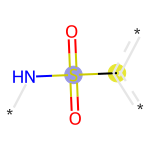


Bit 883:
Tanimoto Similarity: 0.9773
Times Flipped: 1


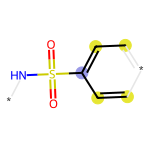


Bit 179:
Tanimoto Similarity: 0.9773
Times Flipped: 1


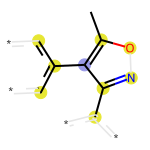


Bit 624:
Tanimoto Similarity: 0.9773
Times Flipped: 1


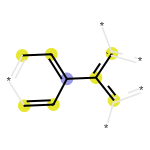


Bit 1057:
Tanimoto Similarity: 0.9773
Times Flipped: 1


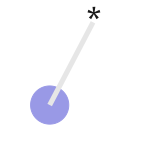


Bit 1873:
Tanimoto Similarity: 0.9773
Times Flipped: 1


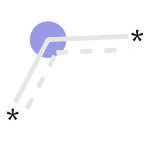


Bit 1746:
Tanimoto Similarity: 0.9773
Times Flipped: 1


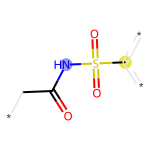


Bit 1747:
Tanimoto Similarity: 0.9773
Times Flipped: 1


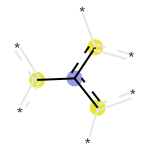


Bit 715:
Tanimoto Similarity: 0.9773
Times Flipped: 1


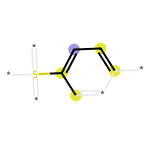


Bit 389:
Tanimoto Similarity: 0.9773
Times Flipped: 1


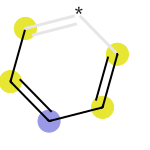



Analysis for anitrazafen (1000 flips):
SMILES: COc1ccc(cc1)c2nnc(C)nc2c3ccc(OC)cc3



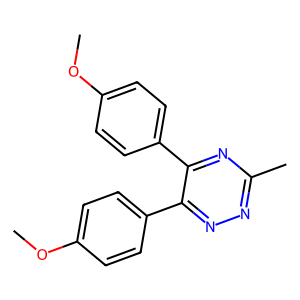


Top 10 Most Impactful Bits:

Bits with structural information:

Bit 1057:
Tanimoto Similarity: 0.9615
Times Flipped: 1


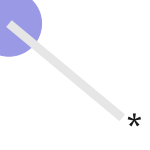


Bit 269:
Tanimoto Similarity: 0.9615
Times Flipped: 1


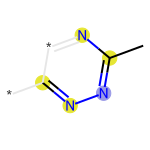


Bit 695:
Tanimoto Similarity: 0.9615
Times Flipped: 1


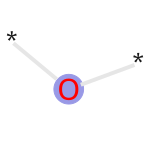


Bit 718:
Tanimoto Similarity: 0.9615
Times Flipped: 1


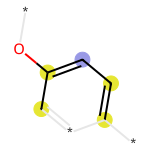


Bit 1164:
Tanimoto Similarity: 0.9615
Times Flipped: 1


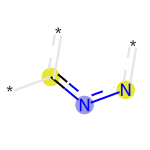


Bit 378:
Tanimoto Similarity: 0.9615
Times Flipped: 1


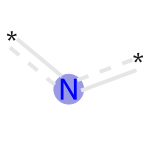


Bit 1722:
Tanimoto Similarity: 0.9615
Times Flipped: 1


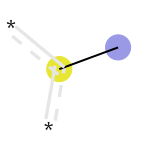


Bit 454:
Tanimoto Similarity: 0.9615
Times Flipped: 1


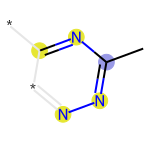


Bit 471:
Tanimoto Similarity: 0.9615
Times Flipped: 1


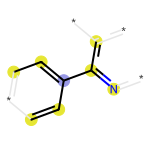


Bit 1750:
Tanimoto Similarity: 0.9615
Times Flipped: 1


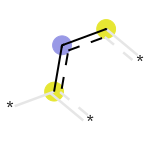

In [29]:
for molecule in ['celecoxib', 'cimicoxib', 'deracoxib', 'parecoxib', 'anitrazafen']:
    analyze_single_molecule(dataframes_dict, molecule, 1000)
    print("\n" + "="*50 + "\n")

In [30]:
def analyze_all_molecules(dataframes_dict, n_flips_filter=None):
    """
    Analyze SMILES strings across all molecules and flip counts
    """
    print("Analysis of Generated Molecules Across All Datasets:\n")
    all_results = {}
    
    for molecule_name, flip_dict in dataframes_dict.items():
        # Skip molecules if they don't have the specified flip count
        if n_flips_filter is not None and n_flips_filter not in flip_dict:
            continue
            
        print(f"\n{'='*50}")
        print(f"Analysis for {molecule_name.upper()}")
        print(f"{'='*50}\n")
        
        for n_flips, df in flip_dict.items():
            if n_flips_filter is not None and n_flips != n_flips_filter:
                continue
                
            print(f"\n{'-'*30}")
            print(f"Number of Bits Flipped: {n_flips}")
            print(f"{'-'*30}")
            
            # Get unique SMILES for this dataset
            unique_smiles = df['Generated_SMILES'].unique()
            
            # Analyze this specific dataset
            results_df = analyze_smiles_differences(unique_smiles, df)
            
            # Store results
            all_results[f"{molecule_name}_{n_flips}"] = results_df
    
    return all_results

def analyze_smiles_differences(smiles_list, full_dataset):
    """
    Analyze a list of SMILES strings and return detailed molecular information
    """
    results = []
    
    # Calculate frequencies from the full dataset
    total_count = len(full_dataset)
    smiles_counts = full_dataset['Generated_SMILES'].value_counts()
    
    # Create a mapping of SMILES to their associated flipped bits
    smiles_to_bits = {}
    for smiles in smiles_list:
        relevant_rows = full_dataset[full_dataset['Generated_SMILES'] == smiles]
        flipped_bits = sorted(relevant_rows['FlippedBitPosition'].unique())
        smiles_to_bits[smiles] = flipped_bits
    
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Warning: Could not parse SMILES: {smiles}")
            continue
            
        # Calculate properties
        formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
        mw = Descriptors.ExactMolWt(mol)
        logp = Descriptors.MolLogP(mol)
        hbd = Descriptors.NumHDonors(mol)
        hba = Descriptors.NumHAcceptors(mol)
        rotatable_bonds = Descriptors.NumRotatableBonds(mol)
        rings = Descriptors.RingCount(mol)
        aromatic_rings = sum(1 for ring in mol.GetRingInfo().AtomRings() 
                           if all(mol.GetAtomWithIdx(i).GetIsAromatic() for i in ring))
        
        # Calculate frequency
        count = smiles_counts.get(smiles, 0)
        frequency = (count / total_count) * 100
        
        results.append({
            'SMILES': smiles,
            'Molecular Formula': formula,
            'Molecular Weight': f"{mw:.2f}",
            'LogP': f"{logp:.2f}",
            'H-Bond Donors': hbd,
            'H-Bond Acceptors': hba,
            'Rotatable Bonds': rotatable_bonds,
            'Total Rings': rings,
            'Aromatic Rings': aromatic_rings,
            'Count': count,
            'Frequency': f"{frequency:.2f}%",
            'Flipped Bits': smiles_to_bits[smiles]
        })
    
    # Convert to DataFrame and sort by frequency
    df = pd.DataFrame(results)
    df = df.sort_values('Count', ascending=False)
    
    # Print summary
    for idx, row in df.iterrows():
        print(f"\nMolecule {idx + 1}:")
        print(f"SMILES: {row['SMILES']}")
        print(f"Formula: {row['Molecular Formula']}")
        print(f"Frequency: {row['Frequency']}")
        print(f"Flipped Bits: {', '.join(map(str, row['Flipped Bits']))}")
        print(f"MW: {row['Molecular Weight']} g/mol")
        print(f"LogP: {row['LogP']}")
        print(f"H-Bond Donors/Acceptors: {row['H-Bond Donors']}/{row['H-Bond Acceptors']}")
        print(f"Rotatable Bonds: {row['Rotatable Bonds']}")
        print(f"Rings (Total/Aromatic): {row['Total Rings']}/{row['Aromatic Rings']}")
        print()
    
    return df

In [31]:
# Analyze for flip counts of 1000 bit flips
analyses_1000 = analyze_all_molecules(dataframes_dict, n_flips_filter=1000)

Analysis of Generated Molecules Across All Datasets:


Analysis for PARECOXIB


------------------------------
Number of Bits Flipped: 1000
------------------------------

Molecule 1:
SMILES: CCC(=O)NS(=O)(=O)c1ccc(-c2c(-c3ccccc3)noc2C)cc1
Formula: C19H18N2O4S
Frequency: 99.40%
Flipped Bits: 0, 1, 4, 8, 9, 12, 15, 19, 20, 24, 25, 26, 27, 29, 37, 38, 40, 42, 43, 45, 48, 57, 58, 62, 63, 66, 68, 71, 72, 74, 75, 77, 79, 80, 81, 84, 87, 88, 89, 90, 92, 93, 95, 96, 97, 102, 103, 109, 110, 112, 115, 116, 118, 120, 121, 122, 123, 129, 130, 131, 133, 136, 138, 143, 144, 146, 152, 153, 154, 155, 161, 163, 164, 165, 167, 170, 172, 174, 176, 177, 178, 179, 181, 183, 184, 185, 186, 188, 189, 190, 193, 200, 201, 202, 205, 206, 207, 208, 209, 211, 216, 220, 221, 223, 225, 226, 234, 237, 238, 239, 240, 241, 242, 244, 246, 247, 254, 255, 261, 263, 266, 269, 272, 273, 274, 275, 276, 277, 279, 281, 282, 285, 286, 289, 290, 291, 295, 296, 298, 299, 300, 302, 312, 313, 317, 320, 321, 323, 324, 325, 327, 32